In [1]:
# data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipeline

# model building
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# accuracy
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score

# other
import joblib
import warnings;warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('healthcare_preprocessed.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,80.0,0,1,0,0,4.662684,3.481240,1,0,0,1,0,0,0,0,1,0
1,1,74.0,1,1,0,0,4.249780,3.310543,1,0,0,1,0,0,0,0,1,0
2,0,69.0,0,0,0,0,4.547435,3.126761,1,0,0,1,0,0,0,0,1,0
3,0,59.0,0,0,0,0,4.332705,3.335770,1,0,0,1,0,0,1,0,0,0
4,0,78.0,0,0,0,0,4.070223,3.186353,1,0,0,1,0,0,1,0,0,0


In [3]:
# Models with pipeline
def models(trainx, testx, trainy, testy, parms=0, cm=False, predictor=-1, save=False):
    """This function takes train test split data pass it through a pipeline
    consisting of selected models and return their respective score.
    
    Parameter
    ----------------------------
    trainx, trainy, testx, testy: x_train, y_train, x_test, y_test
    params: Type Dict -> parameter for model, {applicable only when predictor is not equal to -1
    cm: plot confusion matrix, default set to false
    save: save a pickle file, default set to false
    predictor: Default=-1 {-1: all, 0: Logistic Regression, 1: Decision Tree, 2: XGBoost, 3: SVC, 4: Random Forest}"""

    all_models = [LogisticRegression(), DecisionTreeClassifier(random_state=91), XGBClassifier(random_state=0),
                 SVC(random_state=0, kernel='linear'), RandomForestClassifier(random_state=0)]

    # converting into numpy array
    trainx, testx, trainy, testy = trainx.values, testx.values, trainy.values, testy.values

    # train all models 
    if predictor == -1:
        for model in all_models:
            name = model.__class__.__name__

            # pipeline
            model_pipe = Pipeline([('Scaler', StandardScaler()), ('model', model)])

            # fit predict
            model_pipe.fit(trainx, trainy)
            print(f"{'='*20} {name} {'='*20}")
            print(classification_report(testy, model_pipe.predict(testx)))
            print('Training score: ' + str(model_pipe.score(trainx, trainy)))
            print('Test score: ' + str(model_pipe.score(testx, testy)), '\n')
            if cm:
                plot_confusion_matrix(model_pipe, testx, testy, colorbar=False, cmap='binary')

    # train selected models
    else:
        name = all_models[predictor].__class__.__name__

        # pipeline
        if parms:
            model_pipe = Pipeline([('Scaler', StandardScaler()), ('model', all_models[predictor].set_params(**parms))])
        else:
            model_pipe = Pipeline([('Scaler', StandardScaler()), ('model', all_models[predictor])])

        # fit predict
        model_pipe.fit(trainx, trainy)
        print(f"{'='*20} {name} {'='*20}")
        print(classification_report(testy, model_pipe.predict(testx)))
        print('Training score: ' + str(model_pipe.score(trainx, trainy)))
        print('Test score: ' + str(model_pipe.score(testx, testy)), '\n')
        if cm:
            plot_confusion_matrix(model_pipe, testx, testy, colorbar=False, cmap='binary')

        # save it
        if save:
            filename = f"{name}_model.p"
            joblib.dump(model_pipe, filename)

### Base Model 
* All features were selected

In [4]:
# feature and label
features = df.drop('stroke', axis=1)
label = df['stroke']
print('Features & Label: ', features.shape, label.shape)

# train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=21)
print('Train test split: ', x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Features & Label:  (4390, 17) (4390,)
Train test split:  (3512, 17) (878, 17) (3512,) (878,)


In [5]:
# testing on all models
models(x_train, x_test, y_train, y_test)

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       837
           1       0.00      0.00      0.00        41

    accuracy                           0.95       878
   macro avg       0.48      0.50      0.49       878
weighted avg       0.91      0.95      0.93       878

Training score: 0.9646924829157175
Test score: 0.9533029612756264 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       837
           1       0.25      0.20      0.22        41

    accuracy                           0.94       878
   macro avg       0.61      0.58      0.59       878
weighted avg       0.93      0.94      0.93       878

Training score: 1.0
Test score: 0.9350797266514806 

[00:06:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:111

<font color='orange'>**Note**</font>
* Appart from Decision Tree and XGBoost no other model is able to classify stroke patient.
* Decision tree's recall for stroke patient is 20 which is very low
* XGBoost's recall for stroke patient is even lower than decision tree
* We can not consider these model

### Model with Over and Under Sampling
* All features
* Over and Under sampled training set

In [6]:
# best ratio for over and undersampling

# values to evaluate
over_values = [0.2,0.3,0.4,0.5]
under_values = [0.7,0.6,0.5]


for o in over_values:
  for u in under_values:
        # resampling
        over = SMOTE(sampling_strategy=o, k_neighbors=2, random_state=21)
        under = RandomUnderSampler(sampling_strategy=u, random_state=21)

        balancer = imb_pipeline([
            ('Over', over),
            ('Under', under)])

        x_train_, y_train_ = balancer.fit_resample(x_train, y_train)

        # predicting
        print(f"Over:{o}, Under:{u}")
        models(x_train_, x_test, y_train_, y_test)

Over:0.2, Under:0.7
==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       837
           1       0.17      0.59      0.26        41

    accuracy                           0.84       878
   macro avg       0.57      0.72      0.59       878
weighted avg       0.94      0.84      0.88       878

Training score: 0.8479318734793188
Test score: 0.8428246013667426 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       837
           1       0.13      0.37      0.19        41

    accuracy                           0.86       878
   macro avg       0.55      0.62      0.56       878
weighted avg       0.93      0.86      0.89       878

Training score: 1.0
Test score: 0.857630979498861 

[00:06:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1

<font color='orange'>**Note**</font>
* Its turn out that our best model have achived 0.63 value of `Recall of class 1` 
* We achived best Recall for class 1 when the ratio of SMOTE's Oversampling is 0.2, and Undersampling is 0.7

In [7]:
# Smote for balancing class labels
over = SMOTE(sampling_strategy=0.2, k_neighbors=2, random_state=21)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=21)

balancer = imb_pipeline([
    ('Over', over),
    ('Under', under)])

x_train, y_train = balancer.fit_resample(x_train, y_train)

In [8]:
models(x_train, x_test, y_train, y_test)

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       837
           1       0.17      0.59      0.26        41

    accuracy                           0.84       878
   macro avg       0.57      0.72      0.59       878
weighted avg       0.94      0.84      0.88       878

Training score: 0.8479318734793188
Test score: 0.8428246013667426 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       837
           1       0.13      0.37      0.19        41

    accuracy                           0.86       878
   macro avg       0.55      0.62      0.56       878
weighted avg       0.93      0.86      0.89       878

Training score: 1.0
Test score: 0.857630979498861 

[00:07:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115

<font color='orange'>**Note**</font>
* After data sampling, We have achived highest recall for stroke patient is 0.63.
* SVM classifier is has the higest recall compared to other model but seems little overfitted
* Logistic regression has the 2nd higest recall of 0.59 and also seems generalized model.

### Modelling with Age binned column
* All features
* Over and Under sampled data
* Age column is binned between 4 groups "Toddlers", "Young", "Elder", and "Senior"
* Age breakpoints are as follows 5, 18, 40, 40+

In [9]:
# column binner
def create_bins(col, cut_points, labels=None):
    minval = col.min()
    maxval = col.max()
    break_points = [minval] + cut_points+ [maxval]
    print(break_points)

    if not labels:
        labels = range(len(cut_points) +1)

    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin

In [10]:
# binning age with 4 groups
cut_points = [5, 18, 40];
labels= ["Toddlers", "Young", "Elder", "Senior"]
features_bin = features.copy()
features_bin["AgeGrp"] = create_bins(features_bin["age"], cut_points, labels)

# one hot encoding
features_bin = pd.get_dummies(features_bin, columns=['AgeGrp'])
features_bin.head()

[0.08, 5, 18, 40, 82.0]


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,...,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,AgeGrp_Toddlers,AgeGrp_Young,AgeGrp_Elder,AgeGrp_Senior
0,1,80.0,0,1,0,0,4.662684,3.481240,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,74.0,1,1,0,0,4.249780,3.310543,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,69.0,0,0,0,0,4.547435,3.126761,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,59.0,0,0,0,0,4.332705,3.335770,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,78.0,0,0,0,0,4.070223,3.186353,0,0,...,0,0,1,0,0,0,0,0,0,1


In [11]:
# feature and label
print('Features & Label: ', features_bin.shape, label.shape)

# train test split
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(features_bin, label, test_size=0.2, random_state=21)
print('Train test split: ', x_train_bin.shape, x_test_bin.shape, y_train_bin.shape, y_test_bin.shape)

# Smote
x_train_bin, y_train_bin = balancer.fit_resample(x_train_bin, y_train_bin)
print("Smote: ", x_train_bin.shape, y_train_bin.shape)

Features & Label:  (4390, 21) (4390,)
Train test split:  (3512, 21) (878, 21) (3512,) (878,)
Smote:  (1644, 21) (1644,)


In [12]:
models(x_train_bin, x_test_bin, y_train_bin, y_test_bin)

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       837
           1       0.17      0.59      0.26        41

    accuracy                           0.84       878
   macro avg       0.57      0.72      0.59       878
weighted avg       0.94      0.84      0.88       878

Training score: 0.8485401459854015
Test score: 0.8428246013667426 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       837
           1       0.14      0.41      0.21        41

    accuracy                           0.86       878
   macro avg       0.56      0.65      0.57       878
weighted avg       0.93      0.86      0.89       878

Training score: 1.0
Test score: 0.8553530751708428 

[00:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:111

<font color='orange'>**Note**</font>
* Age binning isn't seems to be improving the model performance

### Modelling with feature selection
* Selected features
* Over and Under sampled data

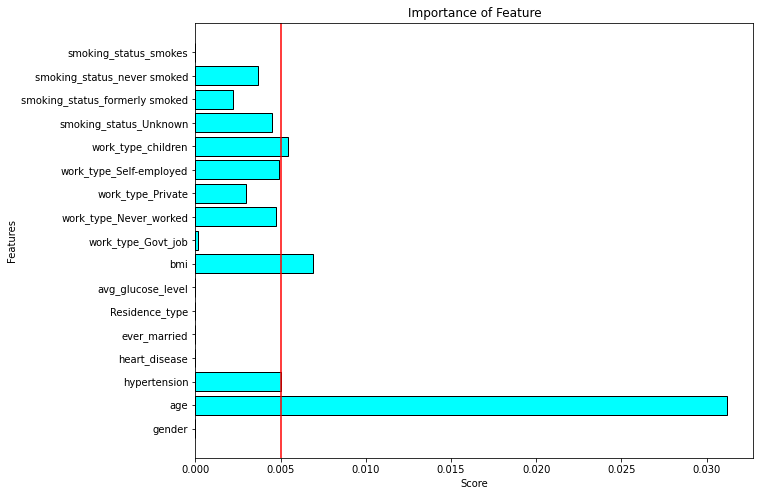

In [13]:
# finding relevat column by information gain
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# score of the dataset
score = mutual_info_classif(df.drop('stroke', axis=1), df['stroke'], random_state=21)

# lets plot it
plt.figure(figsize=(10, 8))
plt.barh(df.drop('stroke', axis=1).columns, score, color = 'cyan', edgecolor='black')
plt.axvline(0.005, color='red')
plt.title('Importance of Feature')
plt.xlabel('Score')
plt.ylabel('Features')
plt.show()

<font color='orange'>**Note**</font>
* According to Information gain's score with theshold 0.005 following features are good stroke predictor
    * ['age', 'hypertension', 'bmi', 'work_type_Self-employed', 'work_type_children']

In [14]:
col = ['age', 'hypertension', 'bmi', 'work_type_Self-employed', 'work_type_children']
features_ig = features[col]

# train test split
x_train_ig, x_test_ig, y_train_ig, y_test_ig = train_test_split(features_ig, label, test_size=0.2, random_state=21)
print('Train test split: ', x_train_ig.shape, x_test_ig.shape, y_train_ig.shape, y_test_ig.shape)

# Smote
x_train_ig, y_train_ig = balancer.fit_resample(x_train_ig, y_train_ig)
print("Smote: ", x_train_ig.shape, y_train_ig.shape)

Train test split:  (3512, 5) (878, 5) (3512,) (878,)
Smote:  (1644, 5) (1644,)


In [15]:
models(x_train_ig, x_test_ig, y_train_ig, y_test_ig)

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       837
           1       0.14      0.71      0.23        41

    accuracy                           0.78       878
   macro avg       0.56      0.74      0.55       878
weighted avg       0.94      0.78      0.84       878

Training score: 0.7652068126520681
Test score: 0.7767653758542141 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       837
           1       0.12      0.44      0.19        41

    accuracy                           0.82       878
   macro avg       0.54      0.64      0.55       878
weighted avg       0.93      0.82      0.87       878

Training score: 0.995742092457421
Test score: 0.8246013667425968 

[00:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/

<font color='orange'>**Note**</font>
* Feature selection did improved the performance of the model
* Logistic regression and Support vector classifier are having same recall score of 0.71 for stroke class
* However Logistic regression has little better precision and more generalized than support vector classifier

### Modelling with Feature selection and Age binning
* Selected Features
* Over and Under sampled data
* Age binning

In [16]:
col = ['age', 'hypertension', 'bmi', 'work_type_Self-employed', 'work_type_children']
features_bin_ig = features_bin[col]

# train test split
x_train_bin_ig, x_test_bin_ig, y_train_bin_ig, y_test_bin_ig = train_test_split(features_bin_ig, label, test_size=0.2, random_state=21)
print('Train test split: ', x_train_bin_ig.shape, x_test_bin_ig.shape, y_train_bin_ig.shape, y_test_bin_ig.shape)

# Smote
x_train_bin_ig, y_train_bin_ig = balancer.fit_resample(x_train_bin_ig, y_train_bin_ig)
print("Smote: ", x_train_bin_ig.shape, y_train_bin_ig.shape)

Train test split:  (3512, 5) (878, 5) (3512,) (878,)
Smote:  (1644, 5) (1644,)


In [17]:
models(x_train_bin_ig, x_test_bin_ig, y_train_bin_ig, y_test_bin_ig)

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       837
           1       0.14      0.71      0.23        41

    accuracy                           0.78       878
   macro avg       0.56      0.74      0.55       878
weighted avg       0.94      0.78      0.84       878

Training score: 0.7652068126520681
Test score: 0.7767653758542141 

==================== DecisionTreeClassifier ====================
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       837
           1       0.12      0.44      0.19        41

    accuracy                           0.82       878
   macro avg       0.54      0.64      0.55       878
weighted avg       0.93      0.82      0.87       878

Training score: 0.995742092457421
Test score: 0.8246013667425968 

[00:07:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/

<font color='orange'>**Note**</font>
* Recall seems to be same as the model with only features selected

### Hyper Parameter Tunning

==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       837
           1       0.13      0.78      0.23        41

    accuracy                           0.75       878
   macro avg       0.56      0.77      0.54       878
weighted avg       0.95      0.75      0.82       878

Training score: 0.7688564476885644
Test score: 0.7528473804100227 



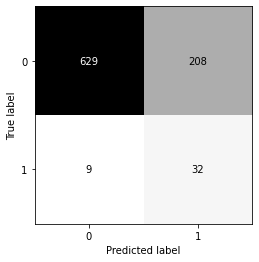

In [18]:
parms = dict(class_weight={0:45, 1:55}, n_jobs=-1)
models(x_train_ig, x_test_ig, y_train_ig, y_test_ig, parms=parms, predictor=0, cm=True)

<font color='orange'>**Note**</font>
* Recall of stroke class is slightly improved after introducing class_weight

==================== SVC ====================
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       837
           1       0.12      0.85      0.21        41

    accuracy                           0.71       878
   macro avg       0.56      0.78      0.52       878
weighted avg       0.95      0.71      0.79       878

Training score: 0.7852798053527981
Test score: 0.7050113895216401 



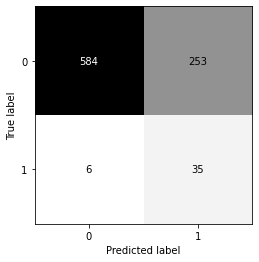

In [19]:
parms = dict(class_weight={0:45, 1:55}, kernel='poly')
# models(x_train_ig, x_test_ig, y_train_ig, y_test_ig, parms=parms, predictor=3, cm=True)
models(x_train_ig, x_test_ig, y_train_ig, y_test_ig, parms=parms, predictor=3, cm=True, save=True)

<font color='orange'>**Note**</font>
* Introducing class weight and selecting 'poly' kernal improved the stroke class recall to 85
* Recall of non-stroke class is also reduced to 70 which is probably not a problem.

==================== SVC ====================
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       837
           1       0.10      0.90      0.17        41

    accuracy                           0.59       878
   macro avg       0.54      0.74      0.45       878
weighted avg       0.95      0.59      0.71       878

Training score: 0.7463503649635036
Test score: 0.5945330296127562 



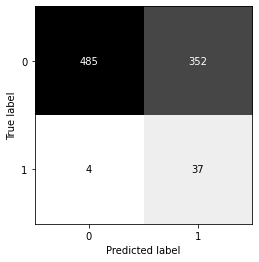

In [20]:
# increase stroke class weightage to 65
parms = dict(class_weight={0:35, 1:65}, kernel='poly', )
models(x_train_ig, x_test_ig, y_train_ig, y_test_ig, parms=parms, predictor=3, cm=True)

<font color='orange'>**Note**</font>
* High weightage to stroke class increase it's recall but also slightly decrease the recall of non-stroke class which in turn decrease the performance of overall model's performance

In [21]:
# kfold
kf_cv = KFold(n_splits=5, shuffle=True) 

# splitting data with KFold
scores = []
i = 0
for train_index, test_index in kf_cv.split(features_ig):
    trainx, testx, trainy, testy = features_ig.iloc[train_index], features_ig.iloc[test_index], label[train_index], label[test_index]
    trainx, trainy = balancer.fit_resample(trainx, trainy)
    parms = dict(class_weight={0:45, 1:55}, kernel='poly')
    print(f'fold: {i}')
    models(trainx, testx, trainy, testy, parms=parms, predictor=3)
    i+=1

fold: 0
==================== SVC ====================
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       845
           1       0.10      0.79      0.17        33

    accuracy                           0.71       878
   macro avg       0.54      0.75      0.50       878
weighted avg       0.95      0.71      0.80       878

Training score: 0.7708714198659354
Test score: 0.714123006833713 

fold: 1
==================== SVC ====================
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       836
           1       0.12      0.71      0.21        42

    accuracy                           0.75       878
   macro avg       0.55      0.73      0.53       878
weighted avg       0.94      0.75      0.82       878

Training score: 0.7931873479318735
Test score: 0.7460136674259681 

fold: 2
==================== SVC ====================
              precision    recall  f1-score   sup

<font color='orange'>**Note**</font>
* Recall for stroke class throughout different fold was as follow;
    * {Fold0: 0.74, Fold1:0.79, Fold2:0.80, Fold3:58, Fold4:0.67}
* Average recall seen was 0.716

In [22]:
# kfold
kf_cv = KFold(n_splits=5, shuffle=True) 

# splitting data with KFold
scores = []
i = 0
for train_index, test_index in kf_cv.split(features_ig):
    trainx, testx, trainy, testy = features_ig.iloc[train_index], features_ig.iloc[test_index], label[train_index], label[test_index]
    trainx, trainy = balancer.fit_resample(trainx, trainy)
    parms = dict(class_weight={0:45, 1:55}, kernel='poly')
    print(f'fold: {i}')
    models(trainx, testx, trainy, testy, predictor=3)
    i+=1

fold: 0
==================== SVC ====================
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       845
           1       0.11      0.70      0.18        33

    accuracy                           0.77       878
   macro avg       0.55      0.73      0.52       878
weighted avg       0.95      0.77      0.84       878

Training score: 0.7720901889092017
Test score: 0.7665148063781321 

fold: 1
==================== SVC ====================
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       842
           1       0.13      0.75      0.23        36

    accuracy                           0.79       878
   macro avg       0.56      0.77      0.55       878
weighted avg       0.95      0.79      0.85       878

Training score: 0.7458866544789763
Test score: 0.7892938496583144 

fold: 2
==================== SVC ====================
              precision    recall  f1-score   su

<font color='orange'>**Note**</font>
* Recall for stroke class throughout different fold was as follow;
    * {Fold0:0.70, Fold1:0.64, Fold2:0.70, Fold3:0.64, Fold4:0.73}
* Average recall seen was 0.716